This notebook describes part of the PeeringDB dataset.  
It consists in IXP metadata (table `ix`), ASes metadata (table `net`), a directed Graph (`DiGraph`) and a table containing the graph's nodes metadata (table `nodes`).

In [2]:
import numpy as np
import pandas as pd
import networkx as nx
import pickle
import matplotlib.pyplot as plt
from sklearn import preprocessing

# Loading preprocessed data
Notes on the preprocessing: 
* All entries are uniquely defined with an index.
 * ASes: the index is the AS number (asn)
 * IXPs: a negative number that I attributed
* The graph is first built from infos present in `netixlan_set` of the API. This makes a bipartite graph (AS-IXP) with links weighted by the router port size (`speed` in the API)
* We want to derive a directed graph: we rely on ASes `info_ratio` attribute, that can take the values `Not Disclosed`, `Heavy In(out)bound`, `Mostly In(out)bound`, `Balanced`.
 * Inbound: a link is created with a weight=`speed` from IXP to AS. Another link of weight $(1-\beta)$*`speed` is created in the other direction
 * Outbound: a link is created with a weight=`speed` from AS to IXP. Another link of weight $(1-\beta)$*`speed` is created in the other direction
 * `Balanced` or `Not Disclosed`: A link in both direction with a weight=`speed`
 * Heavy categories: $\beta=\beta_H=0.95$, Mostly categories: $\beta=\beta_M=0.75$

In [3]:
path = "./"
prefix = "peeringdb_2_dump_"
date = "2021_03_01"

pickle_in = open(path+"nodes/"+prefix+date+".pickle", "rb")
nodes = pickle.load(pickle_in)
pickle_in.close()
nodes = nodes.loc[nodes["port_capacity"]>0] ##port capacity = sum of all ports
print("nodes table summary")
display(nodes.info())

pickle_in = open(path+"ix/"+prefix+date+".pickle", "rb")
ix = pickle.load(pickle_in)
pickle_in.close()
ix = ix.loc[ix["port_capacity"]>0]
print("ix table summary")
display(ix.info())

pickle_in = open(path+"net/"+prefix+date+".pickle", "rb")
net = pickle.load(pickle_in)
pickle_in.close()
net = net.loc[net["port_capacity"]>0]
print("net table summary")
display(net.info())

BETA_H = 0.95
BETA_M = 0.75

edgelist = open(path+"graph/"+format(BETA_H, '.4f')+"_"+format(BETA_M, '.4f')+"_"+prefix+date+".txt", "r")
DiGraph = nx.parse_edgelist(edgelist, nodetype = int, data=(('weight',float),), create_using = nx.DiGraph, delimiter=",")


assert(len(nodes) == len(ix) + len(net))
assert(len(nodes) == len(DiGraph))

print("Total number of nodes:", len(nodes))
print("Total number of IXP:", len(ix))
print("Total number of ASes: ", len(net))
print("Total number of edges: ", len(DiGraph.edges()))

nodes table summary
<class 'pandas.core.frame.DataFrame'>
Int64Index: 12282 entries, 20940 to -893
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           12282 non-null  object 
 1   type           12282 non-null  object 
 2   prev_id        12282 non-null  int64  
 3   AStype         11472 non-null  object 
 4   region         12282 non-null  object 
 5   asn            12282 non-null  int64  
 6   port_capacity  12282 non-null  float64
dtypes: float64(1), int64(2), object(4)
memory usage: 767.6+ KB


None

ix table summary
<class 'pandas.core.frame.DataFrame'>
Int64Index: 810 entries, -1 to -893
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   proto_ipv6        810 non-null    bool  
 1   status            810 non-null    object
 2   url_stats         810 non-null    object
 3   id                810 non-null    int64 
 4   tech_email        810 non-null    object
 5   city              810 non-null    object
 6   policy_email      810 non-null    object
 7   tech_phone        810 non-null    object
 8   media             810 non-null    object
 9   proto_multicast   810 non-null    bool  
 10  ixf_last_import   127 non-null    object
 11  website           810 non-null    object
 12  updated           810 non-null    object
 13  net_count         810 non-null    int64 
 14  policy_phone      810 non-null    object
 15  proto_unicast     810 non-null    bool  
 16  region_continent  810 non-null    object
 1

None

net table summary
<class 'pandas.core.frame.DataFrame'>
Int64Index: 11472 entries, 20940 to 61437
Data columns (total 35 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   status                        11472 non-null  object 
 1   looking_glass                 11472 non-null  object 
 2   route_server                  11472 non-null  object 
 3   netixlan_updated              11472 non-null  object 
 4   info_ratio                    11472 non-null  object 
 5   id                            11472 non-null  int64  
 6   policy_ratio                  11472 non-null  bool   
 7   info_unicast                  11472 non-null  bool   
 8   policy_general                11472 non-null  object 
 9   website                       11472 non-null  object 
 10  allow_ixp_update              11472 non-null  bool   
 11  updated                       11472 non-null  object 
 12  netfac_updated                7121 non

None

Total number of nodes: 12282
Total number of IXP: 810
Total number of ASes:  11472
Total number of edges:  63914


# Selecting the main connected component
Most graph algorithms behave best when the graph has a single connected component 

In [4]:
##I work only with the main connected component. Some entries of nodes, ix and net must be removed
##Main connected component.
#watch out casting DiGraph to Graph is not correct (delete doubled edges). For our use here it will be fine.
components = sorted(nx.connected_components(nx.Graph(DiGraph)), key=len, reverse=True) 
print("Number of connected components", len(components))
print("Percentage of nodes in the graph main connected component", 100.0*len(components[0])/DiGraph.number_of_nodes())
DiGraph = DiGraph.subgraph(components[0])

##Removing entries.
for i in range(1,len(components)):
    component = components[i]
    for node in component:
        #if node is an AS
        if node >= 0:
            net.drop(index=node, inplace=True)
            nodes.drop(index=node, inplace=True)
        #if node is an IXP
        if node < 0:
            ix.drop(index=node, inplace=True)
            nodes.drop(index=node, inplace=True)
            
assert(len(nodes) == len(ix) + len(net))
assert(len(nodes) == len(DiGraph))

Number of connected components 28
Percentage of nodes in the graph main connected component 99.22651034033545


- #### Définition des colonnes pertinentes pour l'étude

In [20]:
list_columns_ix = ['net_count', 'name', 'country', 
                   'notes', 'port_capacity', 'asn', 'ixf_net_count', 'id']

list_columns_net = ['info_scope', 'info_traffic', 'ix_count', 'port_capacity',
                    'info_ratio', 'policy_general','info_type']

## PEERINGDB data visualization

doc attributs peeringDB : https://www.peeringdb.com/apidocs/#operation/list%20net 

- Tableau récapitulatif des données conservées, et de l'étendue de leurs valeurs possibles

| Attribute name        | Meaning           | Possible values  |
| :-------------:       |:---------------:  | :--------------: |
| **info_type** (AS)    | classification de l'AS (NaN pour un IXP) | `Cable/DSL/ISP` `NSP` `Content` `Not Disclosed` `Enterprise` `Educational/Research` `Non-Profit` `Route Server` `""` `Network Services` `Route Collector` `Government`
| **info_ratio** (AS) | politique de communication de l'AS | `"" ` `Not Disclosed` `Heavy Outbound` <br><br>`Mostly Outbound` `Balanced` `Mostly Inbound` `Heavy Inbound` 
| **info_scope** (AS) | origine géographique de la mesure | `Not Disclosed` `Regional` `North America` <br>`Asia Pacific` `Europe` `South America` `Africa` `Australia` `Middle East` `Global` 
| **policy_general** |politique de traffic de l'AS | `""` `Open` `Selective` `Restrictive` `No`| 
| **policy_locations** |politique de traffic de l'AS | `""` `Not Required` `Preferred` `Selective` `Required - International` `Required - US` `Required - EU` 
| **info_traffic** | ordre de grandeur du traffic | `""` `0-20Mbps` `20-100Mbps` `100-1000Mbps`  `1-5Gbps` `5-10Gbps` `10-20Gbps` `20-50Gbps` `50-100Gbps` `100-200Gbps` `200-300Gbps` `300-500Gbps` `500-1000Gbps` `1-5Tbps` `5-10Tbps` `10-20Tbps` `20-50Tbps` `50-100Tbps` `100+Tbps`
| **port_capacity** (both) | bande passante d'un port | value in gigabyte : 1 to 26M8 for AS, 100 to 50M for IXP
| **ix_count** (AS) | nombre d'IXP auquel l'AS se connecte | `int` from 1 to 328
| **net_count** (IXP) | nombre d'AS auquel l'AS se connecte | `int` from 1 to 1309

pour les données scalées :

| Attribute name        | Meaning           | Possible values  |
| :-------------:       |:---------------:  | :--------------: |
| **info_type** (AS)    | classification de l'AS (NaN pour un IXP) | `Cable/DSL/ISP` `NSP` `Content` `Not Disclosed` `Enterprise` `Educational/Research` `Non-Profit` `Route Server` `""` `Network Services` `Route Collector` `Government`
| **info_ratio** (AS) | politique de communication de l'AS | `0.2` `0.4` `0.6` `0.8` `1` 
| **info_scope** (AS) | origine géographique de la mesure | `1/3` `2/3` `1`
| **policy_general** |politique de traffic de l'AS | `0.25` `0.5` `0.75` `1`
| **info_traffic** | ordre de grandeur du traffic | `1/18` `2/18` `3/18` `4/18` `5/18` `6/18` `7/18` `8/18` `9/18` `10/18` `11/18` `12/18` `13/18` `14/18` `15/18` `16/18` `17/18` `1`
| **port_capacity** (both) | bande passante d'un port | std value of port_capacity (from `0` to `1`)
| **ix_count** (AS) | nombre d'IXP auquel l'AS se connecte | `int` scaled
| **net_count** (IXP) | nombre d'AS auquel l'AS se connecte | `int` scaled

In [6]:
net['info_type'].value_counts()

Cable/DSL/ISP           4993
NSP                     2135
Content                 1226
Not Disclosed           1179
Enterprise               625
Educational/Research     500
Non-Profit               320
Route Server             258
                         122
Network Services          27
Route Collector           12
Government                10
Name: info_type, dtype: int64

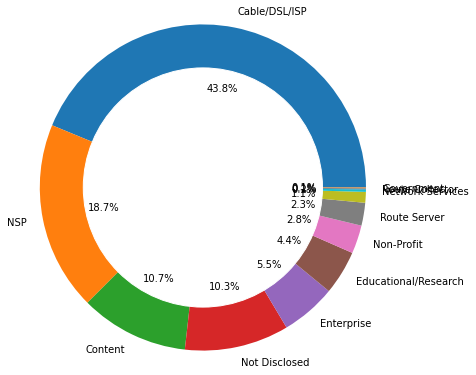

In [10]:
my_circle = plt.Circle( (0,0), 1.1, color='white')
plt.pie(net['info_type'].value_counts(), labels=['Cable/DSL/ISP', 'NSP', 'Content', 'Not Disclosed',
                                                 'Enterprise', 'Educational/Research', 'Non-Profit',
                                                 'Route Server', '', 'Network Services', 
                                                 'Route Collector', 'Government'],autopct='%1.1f%%', 
                                                  pctdistance=0.62, radius=1.5)
fig = plt.gcf()
fig.set_size_inches(5,5)

fig.gca().add_artist(my_circle)
plt.show()

In [ ]:
dataset_info_traffic = pd.DataFrame()

In [ ]:
labels_info_traffic = net['info_traffic'].value_counts().keys()

In [90]:
print(labels_info_traffic)

Index(['', '1-5Gbps', '5-10Gbps', '100-1000Mbps', '10-20Gbps', '20-50Gbps',
       '50-100Gbps', '100-200Gbps', '20-100Mbps', '1-5Tbps', '0-20Mbps',
       '500-1000Gbps', '300-500Gbps', '200-300Gbps', '10-20Tbps', '5-10Tbps',
       '20-50Tbps', '100+Tbps', '50-100Tbps'],
      dtype='object')


In [13]:
_nothing   = net['port_capacity'] [net['info_traffic'] == ""]
_0_20_M    = net['port_capacity'] [net['info_traffic'] == "0-20Mbps"]
_20_100M   = net['port_capacity'] [net['info_traffic'] == "20-100Mbps"]
_100_1000M = net['port_capacity'] [net['info_traffic'] == "100-1000Mbps"]
_1_5G      = net['port_capacity'] [net['info_traffic'] == "1-5Gbps"]
_5_10G     = net['port_capacity'] [net['info_traffic'] == "5-10Gbps"]
_10_20G    = net['port_capacity'] [net['info_traffic'] == "10-20Gbps"]
_20_50G    = net['port_capacity'] [net['info_traffic'] == "20-50Gbps"]
_50_100G   = net['port_capacity'] [net['info_traffic'] == "50-100Gbps"]
_100_200G  = net['port_capacity'] [net['info_traffic'] == "100-200Gbps"]
_200_300G  = net['port_capacity'] [net['info_traffic'] == "200-300Gbps"]
_300_500G  = net['port_capacity'] [net['info_traffic'] == "300-500Gbps"]
_500_1000G = net['port_capacity'] [net['info_traffic'] == "500-1000Gbps"]
_1_5T      = net['port_capacity'] [net['info_traffic'] == "1-5Tbps"]
_5_10T     = net['port_capacity'] [net['info_traffic'] == "5-10Tbps"]
_10_20T    = net['port_capacity'] [net['info_traffic'] == "10-20Tbps"]
_20_50T    = net['port_capacity'] [net['info_traffic'] == "20-50Tbps"]
_50_100T   = net['port_capacity'] [net['info_traffic'] == "50-100Tbps"]
_100_plusT = net['port_capacity'] [net['info_traffic'] == "100+Tbps"]

[]

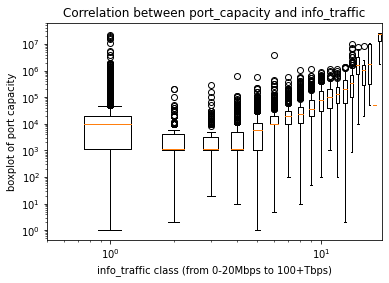

In [23]:
plt.boxplot([_nothing, _0_20_M, _20_100M, _100_1000M, _1_5G, _5_10G, _10_20G, 
             _20_50G, _50_100G, _100_200G, _200_300G, _300_500G,
             _500_1000G, _1_5T, _5_10T, _10_20T, _20_50T, 
            _50_100T, _100_plusT])

plt.xlabel("info_traffic class (from 0-20Mbps to 100+Tbps)")
plt.ylabel("boxplot of port capacity")
plt.title("Correlation between port_capacity and info_traffic")

plt.loglog()
#plt.xticks(np.arange(1,18), labels_info_traffic)

In [97]:
print(np.arange(1,5))

[1 2 3 4]


In [21]:
net[list_columns_net].head()

,info_scope,info_traffic,ix_count,port_capacity,info_ratio,policy_general,info_type
asn,,,,,,,
20940,Global,100+Tbps,211,23992000.0,Heavy Outbound,Open,Content
31800,Global,100-1000Mbps,14,6800.0,Heavy Inbound,Open,Non-Profit
22822,Global,1-5Tbps,104,7331000.0,Mostly Outbound,Selective,Content
3303,Europe,1-5Tbps,50,407700.0,Mostly Inbound,Selective,Cable/DSL/ISP
6079,North America,1-5Tbps,6,370000.0,Mostly Inbound,Selective,Cable/DSL/ISP


In [30]:
net['info_traffic'].value_counts()

                3112
1-5Gbps         2093
5-10Gbps        1263
100-1000Mbps    1149
10-20Gbps       1055
20-50Gbps        900
50-100Gbps       555
100-200Gbps      313
20-100Mbps       231
1-5Tbps          178
0-20Mbps         149
500-1000Gbps     130
300-500Gbps      123
200-300Gbps      117
10-20Tbps         17
5-10Tbps          13
20-50Tbps          5
100+Tbps           3
50-100Tbps         1
Name: info_traffic, dtype: int64

In [110]:
net['info_ratio'].value_counts()

Balanced           3494
Mostly Inbound     3476
Not Disclosed      1965
Mostly Outbound    1078
Heavy Inbound       803
Heavy Outbound      397
                    194
Name: info_ratio, dtype: int64

In [107]:
net['info_traffic'].value_counts()

                3112
1-5Gbps         2093
5-10Gbps        1263
100-1000Mbps    1149
10-20Gbps       1055
20-50Gbps        900
50-100Gbps       555
100-200Gbps      313
20-100Mbps       231
1-5Tbps          178
0-20Mbps         149
500-1000Gbps     130
300-500Gbps      123
200-300Gbps      117
10-20Tbps         17
5-10Tbps          13
20-50Tbps          5
100+Tbps           3
50-100Tbps         1
Name: info_traffic, dtype: int64

In [91]:
ix['port_capacity'].sort_values()

asn
-77          100
-160         100
-271         100
-122         100
-761         110
          ...   
-98     18934200
-15     24737596
-21     39243675
-24     45180600
-102    50251588
Name: port_capacity, Length: 780, dtype: int64

- ### Corrélation entre les données `info_traffic` et `port_capacity`

In [10]:
net['info_traffic'].value_counts()

                3136
1-5Gbps         2105
5-10Gbps        1268
100-1000Mbps    1159
10-20Gbps       1057
20-50Gbps        904
50-100Gbps       557
100-200Gbps      313
20-100Mbps       236
1-5Tbps          178
0-20Mbps         149
500-1000Gbps     130
300-500Gbps      123
200-300Gbps      118
10-20Tbps         17
5-10Tbps          13
20-50Tbps          5
100+Tbps           3
50-100Tbps         1
Name: info_traffic, dtype: int64

In [5]:
net[['info_traffic', 'port_capacity']] [net['info_traffic'] == '1-5Gbps'].sort_values(ascending=False, by='port_capacity').head()

,info_traffic,port_capacity
asn,,
42,1-5Gbps,559507.0
21574,1-5Gbps,223000.0
3856,1-5Gbps,220614.0
267129,1-5Gbps,200000.0
201119,1-5Gbps,160000.0


In [6]:
net[['info_traffic', 'port_capacity']] [net['info_traffic'] == '1-5Gbps'].sort_values(ascending=True, by='port_capacity').head()

,info_traffic,port_capacity
asn,,
52423,1-5Gbps,1.0
264902,1-5Gbps,2.0
61417,1-5Gbps,10.0
37224,1-5Gbps,10.0
31126,1-5Gbps,20.0


array([[<AxesSubplot:title={'center':'port_capacity'}>]], dtype=object)

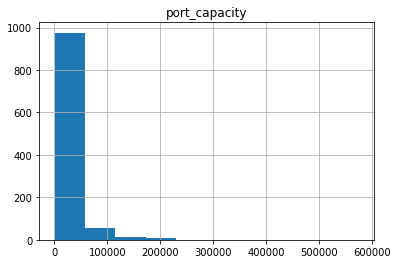

In [7]:
net[['info_traffic', 'port_capacity']] [net['info_traffic'] == '10-20Gbps'].hist()

In [99]:
list_port_capacity_nothing = net['port_capacity'] [net['info_traffic'] == '']

In [100]:
list_port_capacity_un_cinqGpbs = net['port_capacity'] [net['info_traffic'] == '1-5Gbps']

In [101]:
list_port_capacity_dix_vingtGpbs = net['port_capacity'] [net['info_traffic'] == '10-20Gbps']

In [102]:
list_port_capacity_vingt_cinquanteGpbs = net['port_capacity'] [net['info_traffic'] == '20-50Gbps']

In [103]:
print("Smallest port capacity : " + str(list_port_capacity_nothing.min()))
print("Biggest port capacity :  " + str(list_port_capacity_nothing.max()))
print("Mean :                   " + str(list_port_capacity_nothing.mean()))
print("Ecart-type :             " + str(list_port_capacity_nothing.std()))
print("First quartile :         " + str(list_port_capacity_nothing.quantile(0.25)))
print("Mediane :                " + str(list_port_capacity_nothing.quantile(0.5)))
print("Third quartile :         " + str(list_port_capacity_nothing.quantile(0.75)))

Smallest port capacity : 1.0
Biggest port capacity :  21640000.0
Mean :                   81572.38110539845
Ecart-type :             798310.7666564836
First quartile :         1100.0
Mediane :                10000.0
Third quartile :         20000.0


In [93]:
print("Smallest port capacity : " + str(list_port_capacity_un_cinqGpbs.min()))
print("Biggest port capacity :  " + str(list_port_capacity_un_cinqGpbs.max()))
print("Mean :                   " + str(list_port_capacity_un_cinqGpbs.mean()))
print("Ecart-type :             " + str(list_port_capacity_un_cinqGpbs.std()))
print("First quartile :         " + str(list_port_capacity_un_cinqGpbs.quantile(0.25)))
print("Mediane :                " + str(list_port_capacity_un_cinqGpbs.quantile(0.5)))
print("Third quartile :         " + str(list_port_capacity_un_cinqGpbs.quantile(0.75)))

Smallest port capacity : 1.0
Biggest port capacity :  559507.0
Mean :                   10401.761520190024
Ecart-type :             19350.737067419836
First quartile :         1000.0
Mediane :                6000.0
Third quartile :         11000.0


In [94]:
print("Smallest port capacity : " + str(list_port_capacity_dix_vingtGpbs.min()))
print("Biggest port capacity :  " + str(list_port_capacity_dix_vingtGpbs.max()))
print("Mean :                   " + str(list_port_capacity_dix_vingtGpbs.mean()))
print("Ecart-type :             " + str(list_port_capacity_dix_vingtGpbs.std()))
print("First quartile :         " + str(list_port_capacity_dix_vingtGpbs.quantile(0.25)))
print("Mediane :                " + str(list_port_capacity_dix_vingtGpbs.quantile(0.5)))
print("Third quartile :         " + str(list_port_capacity_dix_vingtGpbs.quantile(0.75)))

Smallest port capacity : 100.0
Biggest port capacity :  575000.0
Mean :                   24735.084200567646
Ecart-type :             34512.35642932045
First quartile :         10000.0
Mediane :                20000.0
Third quartile :         30000.0


In [95]:
print("Smallest port capacity : " + str(list_port_capacity_vingt_cinquanteGpbs.min()))
print("Biggest port capacity :  " + str(list_port_capacity_vingt_cinquanteGpbs.max()))
print("Mean :                   " + str(list_port_capacity_vingt_cinquanteGpbs.mean()))
print("Ecart-type :             " + str(list_port_capacity_vingt_cinquanteGpbs.std()))
print("First quartile :         " + str(list_port_capacity_vingt_cinquanteGpbs.quantile(0.25)))
print("Mediane :                " + str(list_port_capacity_vingt_cinquanteGpbs.quantile(0.5)))
print("Third quartile :         " + str(list_port_capacity_vingt_cinquanteGpbs.quantile(0.75)))

Smallest port capacity : 10.0
Biggest port capacity :  1010000.0
Mean :                   41303.41261061947
Ecart-type :             63552.012664169604
First quartile :         11000.0
Mediane :                23500.0
Third quartile :         41000.0


In [108]:
list_port_capacity_vingt_cinquanteGpbs.describe()

count    9.000000e+02
mean     4.146254e+04
std      6.364754e+04
min      1.000000e+01
25%      1.100000e+04
50%      2.400000e+04
75%      4.100000e+04
max      1.010000e+06
Name: port_capacity, dtype: float64

- ### Importance des données <br>
  - `ix_count` : number of exchanges at this facility (pour un AS)
  - `net_count` : number of exchanges at this facility (pour un IXP)


- ### Visualisation et pertinence de la donnée `policy_locations`

In [50]:
net['policy_locations'].value_counts()

Not Required                9962
Preferred                   1218
Required - International      88
                              71
Required - US                 36
Required - EU                 32
Name: policy_locations, dtype: int64

Text(0.5, 1.0, 'Port_capacity percentage')

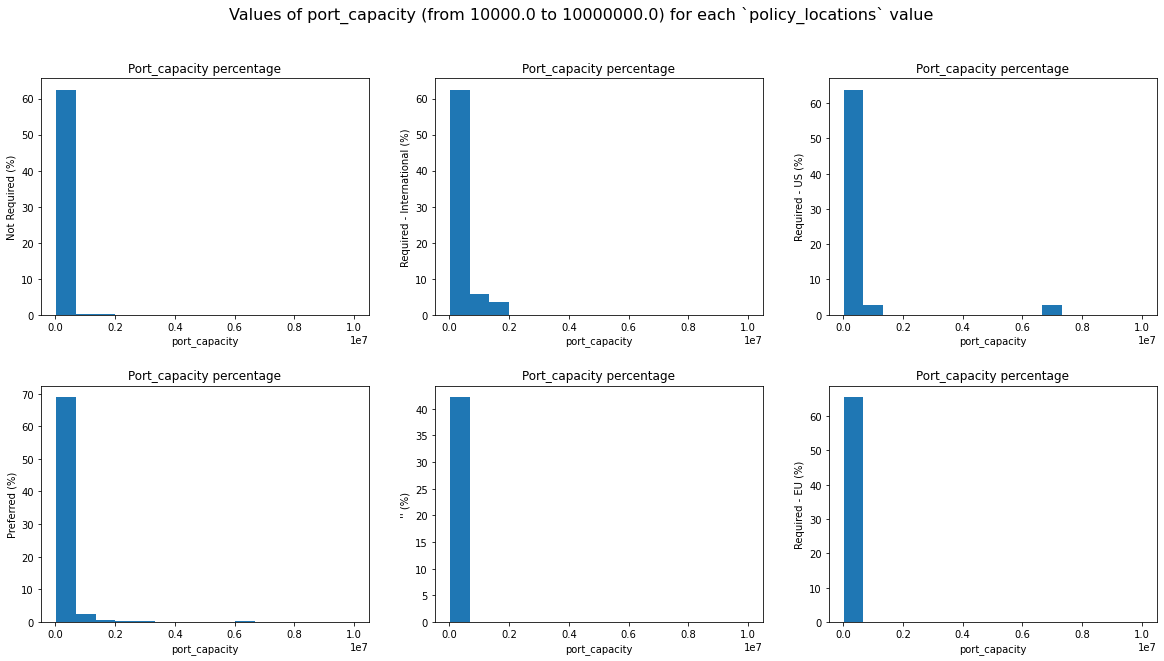

In [27]:
# Parameters values
nb_bins_hist=15
begin_port_value = 1e4
end_port_value   = 1e7
rang_hist=[begin_port_value, end_port_value]

# Configuration of the main figure
fig = plt.figure(figsize=(20,10))
fig.tight_layout(pad=3.0)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.3)
fig.suptitle("Values of port_capacity (from %s to %s) for each `policy_locations` value" % (begin_port_value, end_port_value), fontsize=16)

data_not_required = net['port_capacity'] [net['policy_locations'] == 'Not Required']
data_preferred    = net['port_capacity'] [net['policy_locations'] == 'Preferred']
data_required_int = net['port_capacity'] [net['policy_locations'] == 'Required - International']
data_blank        = net['port_capacity'] [net['policy_locations'] == '']
data_required_US  = net['port_capacity'] [net['policy_locations'] == 'Required - US']
data_required_EU  = net['port_capacity'] [net['policy_locations'] == 'Required - EU']



## 6 histograms displayed

plt.subplot(2,3,1)
plt.hist(data_not_required, 
         bins=nb_bins_hist, range=rang_hist, weights=100*(np.ones(len(data_not_required)) /len(data_not_required)))
plt.xlabel("port_capacity")
plt.ylabel("Not Required (%)")
plt.title("Port_capacity percentage")

plt.subplot(2,3,4)
plt.hist(data_preferred,
         bins=nb_bins_hist, range=rang_hist, weights=100*(np.ones(len(data_preferred)) /len(data_preferred)))
plt.xlabel("port_capacity")
plt.ylabel("Preferred (%)")
plt.title("Port_capacity percentage")

plt.subplot(2,3,2)
plt.hist(data_required_int, 
         bins=nb_bins_hist, range=rang_hist, weights=100*(np.ones(len(data_required_int)) /len(data_required_int)))
plt.xlabel("port_capacity")
plt.ylabel("Required - International (%)")
plt.title("Port_capacity percentage")

plt.subplot(2,3,5)
plt.hist(data_blank, 
         bins=nb_bins_hist, range=rang_hist, weights=100*(np.ones(len(data_blank)) /len(data_blank)))
plt.xlabel("port_capacity")
plt.ylabel("'' (%)")
plt.title("Port_capacity percentage")

plt.subplot(2,3,3)
plt.hist(data_required_US, 
         bins=nb_bins_hist, range=rang_hist, weights=100*(np.ones(len(data_required_US)) /len(data_required_US)))
plt.xlabel("port_capacity")
plt.ylabel("Required - US (%)")
plt.title("Port_capacity percentage")

plt.subplot(2,3,6)
plt.hist(data_required_EU, 
         bins=nb_bins_hist, range=rang_hist, weights=100*(np.ones(len(data_required_EU)) /len(data_required_EU)))
plt.xlabel("port_capacity")
plt.ylabel("Required - EU (%)")
plt.title("Port_capacity percentage")


In [106]:
net['info_scope'].value_counts()

Regional         3614
Europe           1903
Not Disclosed    1527
Global           1264
Asia Pacific     1228
South America     690
North America     646
Africa            226
Australia         172
                   96
Middle East        41
Name: info_scope, dtype: int64